to do: 
 - make trials per session plot nicer 
 - make a version for DLS + DMS lesions

# import 

In [15]:
#import
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# read in the mouse ages
mouse_ages_df = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\mouse_age_data\mouse_ages.csv")


def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name,bbox_inches=0,transparent = True)
    
def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth



# mouse ages start and end of experiments

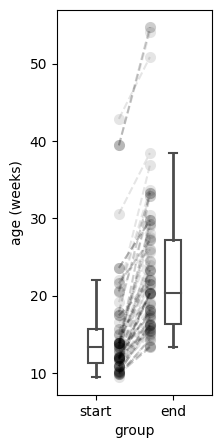

In [ ]:
# mouse ages start and end of experimemt
age_days_1 = mouse_ages_df['age_days']
age_days_2 = mouse_ages_df['age_days.1']

age1_weeks = age_days_1/7
age2_weeks = age_days_2/7
fig, ax = plt.subplots(1,1,figsize=(2,5))
for i in range(len(age1_weeks)):
    ax.plot([0.3,0.7],[age1_weeks[i],age2_weeks[i]],'--o', color = 'k', alpha = 0.1, markeredgewidth = 0, markersize = 8)

dat = list(age1_weeks)+list(age2_weeks)
groups = ['start']*len(age1_weeks) + ['end']*len(age2_weeks) 
plt_df = pd.DataFrame({'group':groups,'age (weeks)': dat })
ax=sns.boxplot( y = 'age (weeks)', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v')

# SaveFig('all-mouse-ages-start-end.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")
SaveFig('all-mouse-ages-start-end.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")



# preprocess

In [5]:
## load in behavioural data:
behav_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\mouse_age_data\training_data\\"
for mouse_file in os.listdir(behav_path):
    #if file exists
    if not 'implant' in mouse_file:
        if not os.path.exists(os.path.join(behav_path,mouse_file) + r"\\t_levels_per_trial_per_session.npy"):
            print(mouse_file)
            t_levels_per_trial_per_session = []

            session_files = os.path.join(behav_path,mouse_file) + '/Preprocessed//'
            for sess_file in os.listdir(session_files):
                file_ = os.path.join(session_files ,sess_file) + "\PreProcessed_RawPokeData.csv"
                # load in the csv
                poke_df = pd.read_csv(file_)

                trial_ids = poke_df['Trial_id']
                # take the inds the first 
                trail_start_inds = []
                for index,item in enumerate(trial_ids):
                    if index == 0:
                        trail_start_inds+=[index]
                    elif not item == trial_ids[index-1]:
                        trail_start_inds+=[index]

                t_levels = list(poke_df['TrainingLevel'][trail_start_inds])

                t_levels_per_trial_per_session += t_levels
                if 50 in t_levels_per_trial_per_session:
                    # break out of the loop
                    break

            # save out npy t levels per trial per session
            np.save(os.path.join(behav_path,mouse_file) + r"\\t_levels_per_trial_per_session.npy",t_levels_per_trial_per_session)






<>:12: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_21696\3002248421.py:12: SyntaxWarning: invalid escape sequence '\P'
  file_ = os.path.join(session_files ,sess_file) + "\PreProcessed_RawPokeData.csv"


# Load in data and pull out training levels across trials

In [35]:
behav_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\mouse_age_data\training_data\\"
# pull out times when the mice reached level 50
trials_to_50 =[]
mice_names = []
for index in tqdm(range(len(os.listdir(behav_path)))):   
    mouse_file = os.listdir(behav_path)[index] 
    if not 'implant' in mouse_file:
        # if not int(mouse_file.split('T')[-1]) in exclude:
        if os.path.exists(os.path.join(behav_path,mouse_file) + r"\\t_levels_per_trial_per_session.npy"):
            level_per_trial = np.load(os.path.join(behav_path,mouse_file) + r"\\t_levels_per_trial_per_session.npy")
            if 50 in level_per_trial:
                mice_names += [mouse_file]
                trials_to_50 += [int(np.where(level_per_trial == 50)[0][0])]
            else:
                mice_names += [mouse_file]
                trials_to_50 += ['50-not-reached']
                print(mouse_file)
                
                

 11%|█         | 9/85 [00:51<07:02,  5.55s/it]

EJT116


 14%|█▍        | 12/85 [01:08<06:58,  5.74s/it]

EJT121


 41%|████      | 35/85 [03:12<04:57,  5.96s/it]

EJT180


 88%|████████▊ | 75/85 [06:44<00:53,  5.33s/it]

EJT78


 98%|█████████▊| 83/85 [07:28<00:11,  5.61s/it]

EJT94


100%|██████████| 85/85 [07:39<00:00,  5.40s/it]


In [60]:
# create data frame with age, trials to crit and mouse name

data = {
    'mouse_name': [],
    'age_weeks': [],
    'trials_to_crit': []
}

for i,name in enumerate(mice_names):
    if not 'implant' in name:
        num = int(name.split('T')[-1])
        if str(num) in np.array(mouse_ages_df['mouse_ID'].values):
            ind = int(np.where(np.array(mouse_ages_df['mouse_ID']==str(num)))[0][0])
            age = (mouse_ages_df['age_days']/7)[ind]
            data['mouse_name'].append(name)
            data['age_weeks'].append(age)
            data['trials_to_crit'].append(trials_to_50[i])

#convert series to data frame
data = pd.DataFrame(data)
        
        

# trials per day, average and across trials

In [62]:
if not os.path.isfile(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\mouse_age_data\AA_trials_per_session.npy"):


    AA_trials_per_session = []
    ## load in behavioural data:
    behav_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\mouse_age_data\training_data\\"

    for index in tqdm(range(len(os.listdir(behav_path)))):   
        mouse_file = os.listdir(behav_path)[index] 
        #if file exists
        if not 'implant' in mouse_file:
            
            print(mouse_file)
            trials_per_session = []
            session_files = os.path.join(behav_path,mouse_file) + '/Preprocessed//'
            for sess_file in os.listdir(session_files):
                file_ = os.path.join(session_files ,sess_file) + "\PreProcessed_RawPokeData.csv"
                # load in the csv
                if os.path.exists(file_):
                    poke_df = pd.read_csv(file_)
                    trials_per_session += [poke_df.Trial_id.unique()[-1]]
                else:
                    print('nope')
            AA_trials_per_session += trials_per_session
            
    out_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\mouse_age_data\AA_trials_per_session.npy"
    np.save(out_path,np.array(AA_trials_per_session))



<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:17: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_21696\1208735177.py:17: SyntaxWarning: invalid escape sequence '\P'
  file_ = os.path.join(session_files ,sess_file) + "\PreProcessed_RawPokeData.csv"


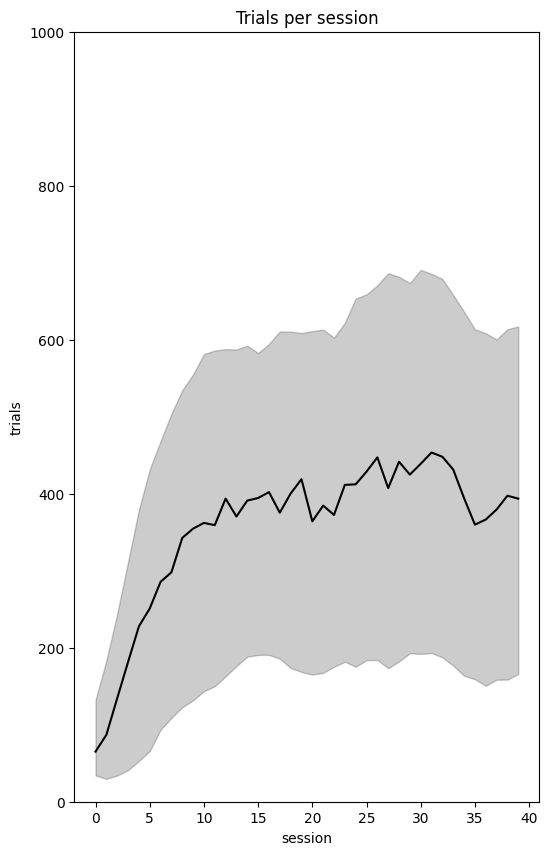

In [63]:
def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors


AA_trials_per_session = np.load(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\mouse_age_data\AA_trials_per_session.npy", allow_pickle=True)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 10))
lesion_data = []
control_data = []

# # Plot each trial set
# for i, trials_per_sess in enumerate(AA_trials_per_session):
#     ax.plot(trials_per_sess, '-', color='blue', alpha=0.2)

# Calculate and plot the mean trials
_mean = []
std_  = []
for item in conactinate_nth_items(AA_trials_per_session)[0:40]:
    _mean.append(np.mean(item))
    std_.append(np.std(item))
ax.plot(convolve_movmean(_mean,1), color='k')

# Plot the standard deviation
ax.fill_between(range(len(_mean)), convolve_movmean(np.array(_mean) - np.array(std_),5), convolve_movmean(np.array(_mean) + np.array(std_),5), color='k', alpha=0.2)

# Set plot labels and limits
ax.set_title('Trials per session')
ax.set_xlabel('session')
ax.set_ylabel('trials')
# ax.set_xlim(0, 20)
ax.set_ylim(0, 1000)

# SaveFig('trials-per-session.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")
SaveFig('trials-per-session.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

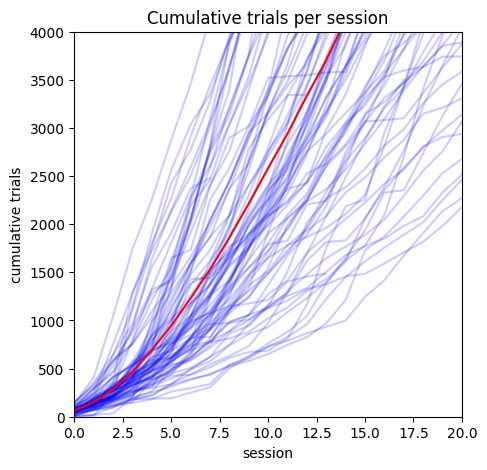

In [10]:

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
lesion_data = []
control_data = []

# Plot each trial set
for i, trials_per_sess in enumerate(AA_trials_per_session):
    ax.plot(np.cumsum(trials_per_sess), '-', color='blue', alpha=0.2)

# Calculate and plot the mean cumulative trials
_mean = []
for item in conactinate_nth_items([np.cumsum(item) for item in AA_trials_per_session]):
    _mean.append(np.mean(item))
ax.plot(_mean[0:60], color='red')

# Set plot labels and limits
ax.set_title('Cumulative trials per session')
ax.set_xlabel('session')
ax.set_ylabel('cumulative trials')
ax.set_xlim(0, 20)
ax.set_ylim(0, 4000)

SaveFig('cum-trials-per-session.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")

# plot age related learning stuff

R-squared: 0.1115490696322714
P-value: 0.008523825394037883


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_21696\730107928.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_data['trials_to_crit'] = np.asarray(masked_data['trials_to_crit'] , dtype=np.float64)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_21696\730107928.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"P-value: {model.pvalues[1]}")


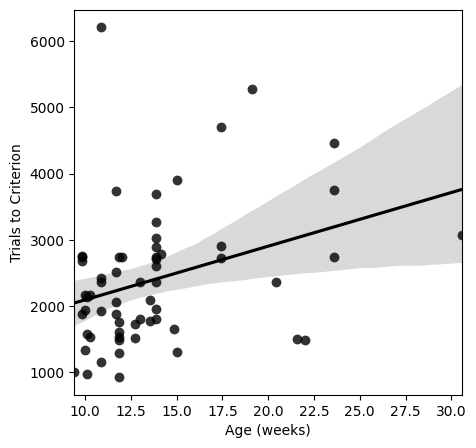

In [71]:
# exclude lesion mice or any that had something weird whihc might have fucked up the learning
# maybe plot it as learning rate?

## mice to exclude (brain lesions etc. ):
#248, 249, 250, 94, 116,117,118,119,121,123,164,179,180,181,182,183,184,185,192,193,153,154,155

# mice i could exclude (some sort of innoquous surgery before training (eg. saline)):
#136, 149, 178, 238, 258,268,269,270, 263,262,255,225,226,162

## exclude mice that had something done to them that altered learning by creating a mask

exclude = [248, 249, 250, 94, 116,117,118,119,121,123,164,179,180,181,182,183,184,185,192,193,153,154,155]
# 136, 149, 178, 238,258,268,269,270,263,262,255,225,226,162]

mask = []
for name in data.mouse_name:
    if not int(name.split('T')[-1]) in exclude:
        mask += [True]
    else:
        mask += [False]

masked_data = data[mask]

# reset the 
masked_data = data[mask]
masked_data['trials_to_crit'] = np.asarray(masked_data['trials_to_crit'] , dtype=np.float64)

fig, ax = plt.subplots(1,1,figsize=(5,5))

sns.regplot(x='age_weeks', y='trials_to_crit', data=masked_data, scatter_kws={'color': 'k', 'linewidths': 0,'s': 50}, line_kws={'color': 'k'},ax=ax)
ax.set_xlabel('Age (weeks)')
ax.set_ylabel('Trials to Criterion')


import statsmodels.api as sm

# Fit the regression model
X = sm.add_constant(masked_data['age_weeks'])
model = sm.OLS(masked_data['trials_to_crit'], X).fit()

# Display the R-squared and p-value
print(f"R-squared: {model.rsquared}")
print(f"P-value: {model.pvalues[1]}")

# SaveFig('age-vs-learning-rate.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")

SaveFig('age-vs-learning-rate.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

In [73]:
def process_lesion_data(data, controls, lesions, lesion_name):
    lesion_data = {
        'mouse_name': [],
        'age_weeks': [],
        'trials_to_crit': [],
        'group': []
    }

    for index, item in enumerate(data.mouse_name):
        mouse_id = int(item.split('T')[-1])
        if mouse_id in controls + lesions:
            lesion_data['mouse_name'].append(item)
            lesion_data['age_weeks'].append(data.age_weeks[index])
            lesion_data['trials_to_crit'].append(data.trials_to_crit[index])
            if mouse_id in controls:
                lesion_data['group'].append('control')
            if mouse_id in lesions:
                lesion_data['group'].append(lesion_name)
    
    return pd.DataFrame(lesion_data)

# h_lesion data
controls_h = [187,191,213,214,227,228]
h_lesion = [248,249,250,255,256,262,263]
hlesion_data = process_lesion_data(data, controls_h, h_lesion, 'h_lesion')

# dls_lesion data
controls_dls = [187,188,189,191,211,212]
dls_lesion = [94,116,117,118,121,123,164]
dls_lesion_data = process_lesion_data(data, controls_dls, dls_lesion, 'dls_lesion')

# dms_lesion data
controls_dms = [187,191,213,214,227,228]
dms_lesion = [79,93,95,113,114,115]
dms_lesion_data = process_lesion_data(data, controls_dms, dms_lesion, 'dms_lesion')

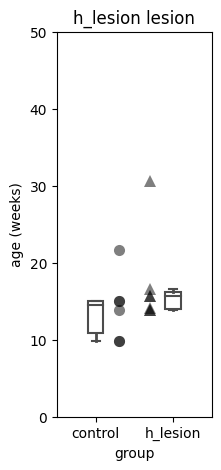

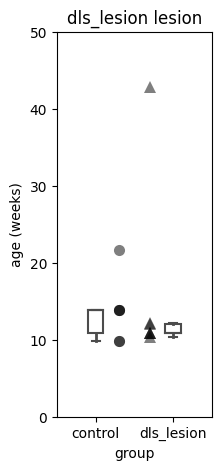

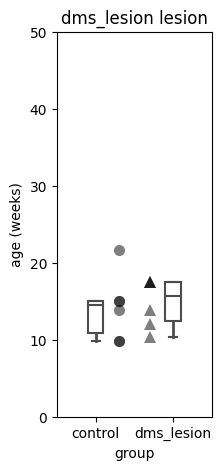

In [87]:
def plot_lesion_data(lesion_data, lesion_name):
    var_str = f'{lesion_name} lesion'

    plt_df = lesion_data
    cont = plt_df.age_weeks[plt_df.group == 'control'].values
    lesi = plt_df.age_weeks[plt_df.group == lesion_name].values

    fig, ax = plt.subplots(1, 1, figsize=(2, 5))
    for i in range(len(cont)):
        ax.plot([0.3], cont[i], '--o', color='k', alpha=0.5, markeredgewidth=0, markersize=8)
    for i in range(len(lesi)):
        ax.plot([0.7], lesi[i], '--^', color='k', alpha=0.5, markeredgewidth=0, markersize=8)

    dat = list(cont) + list(lesi)
    groups = ['control'] * len(cont) + [lesion_name] * len(lesi)
    plt_df = pd.DataFrame({'group': groups, 'age (weeks)': dat})
    ax = sns.boxplot(y='age (weeks)', x='group', data=plt_df, color='blue', width=.2, zorder=10,
                     showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                     showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                     saturation=1, orient='v')

    ax.set_title(var_str)
    
    ax.set_ylim(0,50)


# Example usage:
plot_lesion_data(hlesion_data, 'h_lesion')
# SaveFig('hlesion-control-ages.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")
SaveFig('hlesion-control-ages.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")
plot_lesion_data(dls_lesion_data, 'dls_lesion')
# SaveFig('dls-control-ages.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")
SaveFig('dls-control-ages.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")
plot_lesion_data(dms_lesion_data, 'dms_lesion')
# SaveFig('dms-control-ages.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")
SaveFig('dms-control-ages.pdf.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

100%|██████████| 85/85 [00:58<00:00,  1.46it/s]


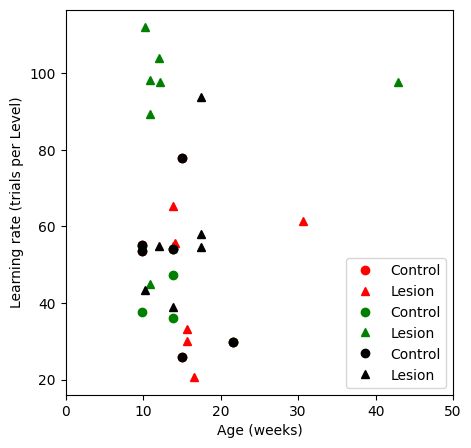

In [89]:
def process_trials_per_level(lesion_data, behav_path):
    trials_per_level = []
    group_ = []
    age_weeks = []
    
    for index in tqdm(range(len(os.listdir(behav_path)))):
        mouse_file = os.listdir(behav_path)[index]
        if mouse_file in lesion_data.mouse_name.values:
            level_per_trial = np.load(os.path.join(behav_path, mouse_file) + r"\\t_levels_per_trial_per_session.npy")
            if 50 in level_per_trial:
                trials_per_level.append(int(np.where(level_per_trial == 50)[0][0]) / 50)
            else:
                trials_per_level.append(np.argmax(level_per_trial) / level_per_trial[np.argmax(level_per_trial)])
            
            age_weeks.append(lesion_data.age_weeks.values[np.where(lesion_data.mouse_name.values == mouse_file)][0])
            if lesion_data.group.values[np.where(lesion_data.mouse_name.values == mouse_file)][0] == 'control':
                group_.append(0)
            else:
                group_.append(1)
    
    return trials_per_level, group_, age_weeks

def plot_age_vs_trials_per_level(ax, age_weeks, trials_per_level, group_, var_string, color,marker):
    """
    Create a scatter plot of age weeks vs trials per level, colored by group.

    Parameters:
    age_weeks (list): List of ages in weeks.
    trials_per_level (list): List of trials per level.
    group_ (list): List indicating group membership (0 for control, 1 for lesion).
    var_string (str): Title for the plot.
    """


    # Convert group_ to a numpy array for easier indexing
    group_ = np.array(group_)

    # Plot control group
    control_mask = group_ == 0
    ax.plot(np.array(age_weeks)[control_mask], np.array(trials_per_level)[control_mask], 'o', color=color, label='Control')

    # Plot lesion group
    lesion_mask = group_ == 1
    ax.plot(np.array(age_weeks)[lesion_mask], np.array(trials_per_level)[lesion_mask], marker, color=color, label='Lesion')





# Create a scatter plot of age weeks vs trials per level, colored by group
fig, ax = plt.subplots(figsize=(5, 5))

# pull in data
trials_per_level, group_, age_weeks = process_trials_per_level(hlesion_data, behav_path)
# plot
plot_age_vs_trials_per_level(ax,age_weeks, trials_per_level, group_,'hipp lesion','red','^')

# SaveFig('hlesion-lrate-vs-age.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")
# SaveFig('hlesion-lrate-vs-age.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

# pull in data
trials_per_level, group_, age_weeks = process_trials_per_level(dls_lesion_data, behav_path)
# plot
plot_age_vs_trials_per_level(ax,age_weeks, trials_per_level, group_,'dls lesion','green','^')

# SaveFig('dls-lrate-vs-age.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")
# SaveFig('dls-lrate-vs-age.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

# pull in data
trials_per_level, group_, age_weeks = process_trials_per_level(dms_lesion_data, behav_path)
# plot
plot_age_vs_trials_per_level(ax,age_weeks, trials_per_level, group_,'dms lesion','k','^')

ax.legend()
# SaveFig('dms-lrate-vs-age.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")

ax.set_xlabel('Age (weeks)')
ax.set_ylabel('Learning rate (trials per Level)')
ax.set_xlim(0, 50)
    

SaveFig('lrate-vs-age.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")


        